In [43]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

### NPZ Dataset to TFRecord

In [33]:
data_path = '../data/'

datafiles = [file.split("/")[-1] for file in os.environ['DATA_SOURCE'].split()]
classmaps = [file for file in datafiles if file.split('.')[-1] == 'csv']
datafiles = [file for file in datafiles if file.split('.')[-1] == 'npz']

print(datafiles)

def load(f):
    return np.load(f)['arr_0']

['k49-train-imgs.npz', 'k49-train-labels.npz', 'k49-test-imgs.npz', 'k49-test-labels.npz']


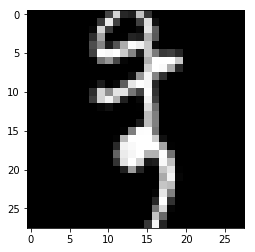

In [49]:
plt.imshow(x_train[0], cmap=plt.cm.gray)

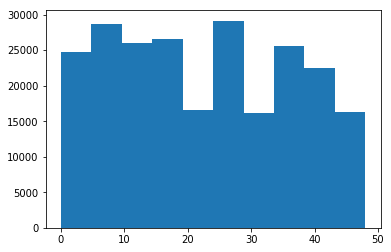

In [52]:
plt.hist(y_train)
plt.show()

In [57]:
batch_size = 200

def get_ds(x, y):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.shuffle(x.shape[0])
    ds = ds.batch(batch_size)
    it = ds.make_initializable_iterator()
    (images, labels) = it.get_next()
    return it, (labels, images)

def get_k49():
    x_train, y_train, x_test, y_test = \
        [load(data_path + file_name) for file_name in datafiles]
    return get_ds(x_train, y_train), get_ds(x_test, y_test)

((<tensorflow.python.data.ops.iterator_ops.Iterator at 0x7f2c79515b38>,
  (<tf.Tensor 'IteratorGetNext_1:1' shape=(?,) dtype=uint8>,
   <tf.Tensor 'IteratorGetNext_1:0' shape=(?, 28, 28) dtype=uint8>)),
 (<tensorflow.python.data.ops.iterator_ops.Iterator at 0x7f2c79542c50>,
  (<tf.Tensor 'IteratorGetNext_2:1' shape=(?,) dtype=uint8>,
   <tf.Tensor 'IteratorGetNext_2:0' shape=(?, 28, 28) dtype=uint8>)))

### Block used to build NN

In [7]:
def residual(x, in_f, momentum, activation, scope, training):
    """
    Non-bottleneck-2D shape detector, not sure if it works at signal
    :param x: input model
    :param in_f: number of input filters
    :param momentum: momentum for batch normalization (should be near 0.99)
    :param activation: activation function
    :param scope: name of scope, please use scope_describer
    :param training: determine if its training operation for BN
    :return: output model
    """
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
        model = tf.layers.conv1d(x, in_f, 3, 1, 'SAME')
        model = tf.layers.batch_normalization(model, momentum=momentum, training=training)
        model = activation(model)

        model = tf.layers.conv1d(model, in_f, 3, 1, 'SAME')
        model = tf.layers.batch_normalization(model, momentum=momentum, training=training)
        model = activation(model)

        # model = tf.layers.conv1d(model, in_f, 3, 1, 'SAME')
        # model = tf.layers.batch_normalization(model, momentum=momentum, training=training)
        # model = activation(model)
        #
        # model = tf.layers.conv1d(model, in_f, 3, 1, 'SAME')
        # model = tf.layers.batch_normalization(model, momentum=momentum, training=training)
        # model = activation(model)

        model = model + x

    return model


def down_sample(x, in_f, out_f, momentum, activation, training, scope, conv, max_pooling):
    """
    Down sampling convolution 2D block with side pooling
    BN + concat + activation
    :param max_pooling: max_pooling layer function
    :param conv: conv layer function
    :param x: input model
    :param in_f: number of input filters
    :param out_f: number of output filters
    :param momentum: momentum for batch normalization (should be near 0.99)
    :param activation: activation function
    :param scope: name of scope, please use scope_describer
    :param training: determine if its training operation for BN
    :return: output model
    """
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
        model_conv = conv(x, out_f - in_f, 3, 2, 'SAME')
        # tf.contrib.layers.summaries.summarize_weights()
        # tf.contrib.layers.summaries.summarize_biases()
        # tf.summary.histogram("down_sample/" + scope, model_conv)

        model_pool = max_pooling(x, 3, 2, 'SAME')

        model = tf.concat([model_conv, model_pool], axis=-1)

        model = tf.layers.batch_normalization(model, momentum=momentum, training=training)
        model = activation(model)

    return model


def down_sample_2d(x, in_f, out_f, momentum, activation, training, scope):
    return down_sample(x, in_f, out_f, momentum, activation, training, scope,
                       tf.layers.conv2d, tf.layers.max_pooling2d)


def down_sample_1d(x, in_f, out_f, momentum, activation, training, scope):
    return down_sample(x, in_f, out_f, momentum, activation, training, scope,
                       tf.layers.conv1d, tf.layers.max_pooling1d)

### Model definition

In [35]:
def get_ema_getter(ema, training):
    def ema_getter(getter, name, *args, **kwargs):
        var = getter(name, *args, **kwargs)
        if ema is not None and not training:
            ema_var = ema.average(var)
            return ema_var if ema_var else var
        return var

    return ema_getter


def get_model(in_image, training, scope, ema, first_filter=64):
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE,
                           custom_getter=get_ema_getter(ema, training),
                           regularizer=tf.contrib.layers.l2_regularizer(1e-3)
                           ):
        model = in_image
        model = down_sample_1d(model, model.shape[-1], first_filter, momentum=0.999, activation=tf.nn.relu,
                               training=training,
                               scope='conv_1')
        model = residual(model, model.shape[-1], momentum=0.99, activation=tf.nn.relu, training=training,
                         scope='residual_1_1')

        model = residual(model, model.shape[-1], momentum=0.99, activation=tf.nn.relu, training=training,
                         scope='residual_1_2')

        model = down_sample_1d(model, model.shape[-1], 2 * first_filter, momentum=0.999, activation=tf.nn.relu,
                               training=training,
                               scope='conv_2')
        model = residual(model, model.shape[-1], momentum=0.99, activation=tf.nn.relu, training=training,
                         scope='residual_2_1')

        model = residual(model, model.shape[-1], momentum=0.99, activation=tf.nn.relu, training=training,
                         scope='residual_2_2')

        model = down_sample_1d(model, model.shape[-1], 4 * first_filter, momentum=0.999, activation=tf.nn.relu,
                               training=training,
                               scope='conv_3')

        model = residual(model, model.shape[-1], momentum=0.99, activation=tf.nn.relu, training=training,
                         scope='residual_3_1')

        model = residual(model, model.shape[-1], momentum=0.99, activation=tf.nn.relu, training=training,
                         scope='residual_3_2')

        model = tf.layers.flatten(model)

        model = tf.layers.dense(model, 200, activation=tf.nn.relu)
        model = tf.layers.dense(model, 2)

        model = tf.reshape(model, [-1, 1, 2])

        return model
    
global_step = tf.train.get_or_create_global_step()
ema = tf.train.ExponentialMovingAverage(0.999, global_step)

In [63]:
def train(sess, iterator, train_op, loss, acc, num_epochs):
    for i in range(num_epochs):
        sess.run(iterator.initializer)
        part_metrics = [[], []]
        while True:
            try:
                _, l, acc = sess.run([train_op, loss, acc])
                part_metrics[0].append(l)
                part_metrics[1].append(acc)
            except tf.errors.OutOfRangeError:
                break
    print(np.mean(np.array(part_metrics), axis=0))
    # print('Total epoch {0} loss: {1}'.format(i, sum(total_loss) / len(total_loss)))
    
def test(sess, test_output, acc):
    sess.run(iterator.initializer)
    metrics = [[]]
    while True:
        try:
            acc = sess.run([acc,])
            part_metrics[0].append(acc)
        except tf.errors.OutOfRangeError:
            break
    print(np.mean(np.array(part_metrics), axis=0))

In [ ]:
# IN PROGRESS
(train_iterator, (x_train, gt_train)), (test_iterator, (x_test, gt_test)) = get_k49()

num_classes = max(y_train) + 1
model = get_model(x_train, True, "model", ema, 32)

train_output = model()

gt_train_one = tf.one_hot(gt_train, num_classes)
gt_test_one = tf.one_hot(gt_test, num_classes)

test_label = tf.argmax(test_output_tensor, num_classes)
train_label = tf.argmax(train_output_tensor, num_classes)

test_acc, test_acc_op = tf.metrics.accuracy(labels=test_label,
                                                predictions=tf.argmax(test_output, num_classes))
train_acc, train_acc_op = tf.metrics.accuracy(labels=train_label,
                                                predictions=tf.argmax(train_output, num_classes))